# Steady-State Growth and Optimal Resource Allocation
Griffin Chure - January 26, 2021

In [1]:
import numpy as np
import pandas as pd 
import altair as alt
import sympy as sp
import panel as pn
import scipy.stats
import growth.viz
colors, palette = growth.viz.altair_style()

In this notebook, I derive and explore a simple model which describes steady-state balanced bacterial growth on a single nutrient (i.e. carbon) source. 

## Protein Synthesis
We begin by considering the  influence of peptide bond formation (translation or *protein syntehsis*) as the most resource-intensive process involved in bacterial growth. In balanced, exponential steady-state, the cellular composition  at any point in remains the same with the synthesis of new proteins being balanced by dilution via cell division. In this mode of growth, the total protein mass of the cell $M$ grows linearly with the cellularl growth rate $\lambda$,

$$
\frac{dM}{dt} = \lambda M. \tag{1}
$$

Assuming we have an unlimited pool of precursors (meaning, tRNAs charged with amino acids) at our disposal, we can write Equation 1 in terms of the total number of translating ribosomes ribosomes $N_R^{(active)}$ as 

$$
\frac{dM}{dt} = N_R^{(active)} k_R, \tag{2}
$$

where the rate $k_R$ is the effective translation rate per active ribosome with dimensions of [MT$^{-1}$]. Here, we cast this in terms of *actively translating ribosomes*, but that does not reflect the *total* number of ribosomes. There will always exist some minimum number of ribosomes $N_R^\text{(inactive)}$ that are not actively translating. Together, the sum of the actively translating and inactive ribosome pools yields the total ribosome copy number, 

$$
N_R = N_R^\text{(active)} + N_R^\text{(inactive)}. \tag{3}
$$

To speak in terms of total ribosome copy number $N_R$, we can restate Equation 2 using the conservation of mass in Equation 3 to yield

$$
\frac{dM}{dt} = (N_R - N_R^\text{(inactive)}) k_R. \tag{4}.
$$


By Equation 1, we can relate this to the growth rate $\lambda$ by simple rearrangement to yield

$$
\lambda = \frac{1}{M}\frac{dM}{dt} = \frac{\left(N_R - N_R^\text{(inactive)}\right) k_R}{M}. \tag{4}
$$

Rather than working in terms of ribosome copy numbers (which can be difficult to measure), we can define the fraction of the entire protein mass that is ribosomal $\phi_R$, defined as 

$$
\phi_R = \frac{M_R}{M}, \tag{5}
$$


where $M_R$ is the the mass of *all* ribosomes in the cell. We state that each ribosome has a proteinaceous mass of $m_R$, the total ribosomal mass $M_R$ can be calculated as $M_R = m_R N_R$. Thus, by computing the mass fraction, we can resetate Equation 5 as 

$$
\lambda = \frac{\left(M_R - M_R^\text{(inactive)}\right)}{m_R}\frac{k_R}{M} = \frac{k_R}{m_R}\left(\phi_R - \phi_R^\text{(inactive)}\right) = \gamma\left(\phi_R - \phi_R^\text{(inactive)}\right), \tag{6}
$$

where we have introduced the term $\gamma = \frac{k_R}{m_R}$. This term, commonly referred to as the *translational efficiency* is the ratio of the average translation rate $k_R$ and the mass of a single ribosome $m_R$ and thus has dimensions of [T$^{-1}$]. This term capture what fraction of a ribosomes mass synthesized per unit time, or alternatively, the inverse $\frac{1}{\gamma}$ is the length of time it takes to synthesize one ribosomes worth of peptide mass.  For *E. coli*, a sisngle ribosome consisits of ≈ 7500 amino acids and has a maximal translation rate of ≈ 17 amino acids / second, yielding

$$
\gamma = {k_R}{m_R} \approx \frac{17\,\text{amino acids / s}}{7500\,\text{amino acids}} \approx 2.2 \times 10^{-3} \text{ribosomes / sec}; \frac{1}{\gamma} \approx 400 \frac{\text{s}}{\text{ribosome}}.
$$.

Equation 6 provides a means to calculate the cellular growth rate so long as one knows the  translational efficiency $\gamma$ and the proteome mass fraction $\phi_R$. Alternatively, knowing the growth rate $\lambda$ and having measured the proteome mass fraction $\phi_R$, one can easily infer the inactive ribosomal mass fraction and the translational efficiency $\gamma$ by performing a simple linear regression of 

$$
\phi_R = \phi_R^\text{(inactive)} + \frac{\lambda}{\gamma}. \tag{7}
$$

Below, we load data from a variety of proteomic and other studies where the ribosomal mass fraction (either by RNA/protein ratio or via proteomics) and the growth rate were measured and perform this simple inference. 

In [2]:
# Load the data
mass_fraction = pd.read_csv('../../data/mass_fraction_compiled.csv')

# Do the simple inference of the parameters
popt = scipy.stats.linregress(mass_fraction['growth_rate_hr'], mass_fraction['mass_fraction'])

# Compute the trendline
growth_rate = np.linspace(0, 2, 100)
trend = popt[1] + popt[0] * growth_rate
fit_df = pd.DataFrame(np.array([growth_rate, trend]).T, 
                      columns=['growth_rate_hr', 'mass_fraction'])

fit = alt.Chart(fit_df).mark_line(color=colors['black'], size=2).encode(
                x=alt.X(field='growth_rate_hr', type='quantitative', title='growth rate [hr\u207b\u00B9]'),
                y=alt.Y(field='mass_fraction', type='quantitative', title='ribosomal mass fraction'))
# Set up the plot
base = alt.Chart(mass_fraction).encode(
                x=alt.X(field='growth_rate_hr', type='quantitative', title='growth rate [hr\u207B\u00B9]'),
                y=alt.Y(field='mass_fraction', type='quantitative', title='ribosomal mass fraction'),
                color=alt.Color(field='source', type='nominal', title='data source'),
                shape=alt.Shape(field='source', type='nominal'))
points = base.mark_point(size=100,opacity=0.75)

print(f"""
Estimated Parameters
---------------------
γ ≈ {1/popt[0]:0.0f} hr^-1
Φ_R (inactive) = {popt[1]:0.2f}
""")
(points + fit).interactive()


Estimated Parameters
---------------------
γ ≈ 10 hr^-1
Φ_R (inactive) = 0.04



alt.LayerChart(...)

The linear relation given in Equation 7, and subsequent parameteter estimates, provide some more context for what the  parameter $\phi_R$  $^\text{(inactive)}$ means. When the growth rate is 0, protein synthesis is no longer proceeding meaning that *all* ribosomes in the cell are inactive. Thus, this implies that the parameter $\phi_R^\text{(inactive)}$ represents the *minimum* fraction of the proteome that can be occupied by ribosomal mass. Thus, going forward, we will make the definition

$$
\phi_R^\text{(inactive)} \equiv \phi_R^\text{(min)}. \tag{8}
$$

such that the meaning of $\phi_R^\text{(min)}$ is clear. 


## Nutrient Transport and General Metabolism
Thus far we have only considered the synthesis of proteis as the rate-limiting step of growth (sometimes referred to as *translation limited growth*). In doing so, we have made the assumption *a priori* that the concentration of precursors (think amino acids or charged tRNA) are in sufficient abundance. Here, we extend the model to consider the transport or synthesis of nutrients, which we will approximate as being a type of amino acid. 

Consider some amino acid $a$ (not specificially *alanine*), whose total mass in the cell is $M_a$. As the cell grows, will need to transport or synthesize at some flux $J_a$ to at least match the rate at which it is being consumed. The dynamics of this process can be written as

$$
\frac{dM_a}{dt} = J_a - \beta \frac{dM}{dt}, \tag{9}
$$

where $\beta$, defined on the range [0, 1], corresponds to the frequency at which $a$ is being incorporated into the new cell mass. For example, if we consider that all 20 amino acids are used in equal measure, the parameter $\beta = \frac{1}{20}$ to indicate that one out of every 20 amino acids is the nutrient $a$. In addition, we can stipulate that there must be a residual pool of mass $M_a^\text{(residual)}$ such that the kinetics of the translation isn't slowed. Noting that rather than working in the space of absolute mass $M_a$, we can again work in the language of mass fraction by defining 

$$
\theta_a = \frac{M_a}{M}, \tag{10}
$$

where we have chosen $\theta$ as to note that it is possible for $\theta > 1$ where as it is not the case for $\phi$. Thus, to impose the limit that there must be a residual concentration of $a$ at a given mass fraction $\theta_a$, we can amend Equation 9 to read 

$$
\frac{dM_a}{dt} = J_a - \beta \frac{dM}{dt} - \theta_a \frac{dM}{dt} = J_a - \left( \beta + \theta_a\right)\frac{dM}{dt}. \tag{11}
$$

We can express the entire dynamics enumerated in Equation 11 in terms of the nutrient mass fraction $\theta_a$ by dividing Equation 11 by $M$, yielding
$$
\frac{d\theta_a}{dt} = \frac{J_a}{M} - \frac{\beta +  \theta_a}{M}\frac{dM}{dt}. \tag{12}
$$


Using the relation given in Equation 1, we can state Equation 12 in terms of the growth rate as 
$$
\frac{d\theta_a}{dt} = \frac{J_a}{M} - \lambda\left(\beta + \theta_a\right). \tag{13}
$$

In steady-state, the mass fraction of the nutrient $\theta_a$ is constant, meaning that Equation 13 is equal to zero. Therefore, we can state that

$$
\lambda = \frac{J_a}{M\left(\beta + \theta_a\right)}. \tag{14}
$$

The flux or synthesis parameter $J_a$ reflects the concerted action of an array of metabolic proteins involving enzymatic pathways and transporters. We can abstract this complicated process by stating that all of the metabolic proteins involved in this synthesis and transport have a combined mass $M_A$, proceeding with a generalized rate $k_A$ which has units of nutrient mass produced/transported per unit mass of metabolic protein. This allows us to define the flux as 

$$
J_a = k_P M_P. \tag{15}
$$

Plugging Equation 15 into Equation 14 yields a complete expression for the growth rate,

$$
\lambda = \frac{k_P}{\beta + \theta_a} \frac{M_P}{M} = \frac{k_P}{\beta + \theta_a} \phi_P. \tag{16}
$$

where $\phi_P$ is the mass fraction of the proteome occupied by metabolic proteins. In our section on *Protein Synthesis* we noted that there existed a maximum and minimum fraction fo teh total cellular proteome that can be occupied by ribosomes, $\phi_R^\text{(min)}$ and $\phi_R^\text{(max)}$. In order for the ribosomal mass fraction of the proteome to be able to change, there must be a comensurate change in the mass fraction in the rest of the proteome. We can state this mathematically by noting that the mass of the proteome must be partitioned between metabolic and ribosomal proteins,

$$
\phi_P + \phi_R = \phi_R^\text{(max)}. \tag{17}
$$

Thus, as $\phi_P$ gets smaller and smaller, the fraction of the proteome occupied by the ribosomes grows larger. Using this simple constraint, we can define expression for the growth rate given by Equation 16 in terms of the ribosomal mass fraction as 

$$
\lambda = \frac{k_P}{\beta + \theta_a} \left(\phi_R^\text{(max)} - \phi_R\right). \tag{18}
$$

In standard physiological conditions, the standing mass fraction pool of amino acids is small compared to the number being incorporated into protein at any point in time. In this regime, we can make the mathematical approximation that 

$$
\beta + \theta_a \approx \beta, \tag{19}
$$

allowing us to simplify Equation 18 to

$$
\lambda = \nu\left(\phi_R^\text{(max)} - \phi_R\right), \tag{20}
$$

where we have introduced $\nu = \frac{k_P}{\beta}$ which defines the synthesis/transport rate of nutrients to their frequency of usage. As we did in the previous section, we can rewrite Equation 20 to define the ribosomal mass fraction $\phi_R$ as a function of the growth rate as 

$$
\phi_R = \phi_R^\text{(max)} - \frac{\lambda}{\nu}. \tag{21}
$$

Equation 21 immediately illustratese that, for a fixed value of $\nu$, the ribosomal mass fraction decreases relative as the growth rate increases. In their seminal 2010 work, Matthew Scott and company decreased the growth rate of *E. coli* in a single growth medium by titrating in different amounts of chloramphenicol, an antibiotic which reversibly inactivates ribosomes. Thus, as $\nu$ is dictated by the identity of the growth medium, adding chloramphenicol acts as a means to decrease $\lambda$, theoretically *increasing* the ribosomal mass fraction. Below we plot these data and estimate the relevant parameters $\nu$ and $\phi_R^\text{(max)}$ for each minimal growth medium.

In [40]:
# Load data for Scott et al 2010, Fig 2AC
scott_data = pd.read_csv('../../data/Scott2010_chlor_inhibition_minimal.csv')
scott_data['mass_fraction'] = scott_data['RNA_protein_ratio'] * 0.4855 # Converts RNA/Protein to ribosome mass fraction

# Set up the plot of the points
points = alt.Chart(scott_data).mark_point(size=80).encode(
                    x=alt.X(field='growth_rate_hr', type='quantitative', title='growth rate [hr\u207b\u00b9]'),
                    y=alt.Y(field='mass_fraction', type='quantitative', title='ribosomal mass fraction',
                           scale=alt.Scale(domain=[0, 0.4])),
                    color=alt.Color(field='medium', type='nominal', 
                                    title='growth medium'),
                    shape=alt.Shape(field='chloramphenicol_conc_uM', type='nominal', title='chloramphenicol [µM]'))

# For each growth medium, do the fit. 
fit_dfs = []
growth_rate = np.linspace(0, 1, 100)
print("""
Estimated Parameters
--------------------
""")
for g, d in scott_data.groupby(['medium']):
    popt = scipy.stats.linregress(d['growth_rate_hr'],d['mass_fraction'])
    print(f'Growth medium {g}: Φ_R max ≈ {popt[1]:0.2f}; ν ≈ {-1 * popt[0]**-1:0.1f}')
    _df = pd.DataFrame([])
    _df['growth_rate_hr'] = growth_rate
    _df['mass_fraction'] = popt[1] + popt[0] * growth_rate
    _df['medium'] = g
    fit_dfs.append(_df)
fit_df = pd.concat(fit_dfs, sort=False)

# Generate the plot with the fits. 
fit = alt.Chart(fit_df).mark_line(size=2).encode(
                x=alt.X(field='growth_rate_hr', type='quantitative', title='growth rate [hr\u207b\u00b9]'),
                y=alt.Y(field='mass_fraction', type='quantitative', title='ribosomal mass fraction'),
                color=alt.Color(field='medium', type='nominal', title='growth medium')
)
(points + fit).interactive()


Estimated Parameters
--------------------

Growth medium M63 + glucose: Φ_R max ≈ 0.31; ν ≈ 2.9
Growth medium M63 + glycerol: Φ_R max ≈ 0.37; ν ≈ 1.4
Growth medium cAA + glucose: Φ_R max ≈ 0.32; ν ≈ 5.5
Growth medium cAA + glycerol: Φ_R max ≈ 0.29; ν ≈ 4.3


alt.LayerChart(...)

From this inference, we can come to the conclusion that the maximum ribosomal mass fraction $\phi_R^\text{(max)}$ is largely independent of the growth medium and is around $\approx$ 0.3 - 0.4. The nutritional capacity $\nu$ is (as expected), dependent on the growth medium. 

We now have in hand two "growth laws" for exponential steady-state growth. Using Equations 7 and 20, we can enumerate a mathematical expression for the growth rate as a function of $\nu$, $\gamma$, $\phi_R^\text{max}$ and $\phi_R^\text{min}$ as

$$
\lambda = \frac{\phi_R^\text{(max)} - \phi_R^\text{(min)}}{\frac{1}{\nu} + \frac{1}{\gamma}}. \tag{22}
$$




In [86]:
# Define the parameter ranges. 
nu_range = np.round(np.linspace(1, 5, 20), decimals=2)
gamma_range = np.linspace(20, 1, 20)

# Define the maximum and minimum bounds of the ribosomal mass fraction
phi_R_max = 0.35
phi_R_min = 0.04

# Compute the grid.
nu_mesh, gamma_mesh = np.meshgrid(nu_range, gamma_range)
growth_rate = (phi_R_max - phi_R_min) / (nu_mesh**-1 + gamma_mesh**-1)

# Assemble teh dataframe
df = pd.DataFrame({'nu': nu_mesh.ravel(),
                   'gamma': gamma_mesh.ravel(),
                   'growth_rate_hr': growth_rate.ravel()})

# Plot the heatmap
heatmap = alt.Chart(df).mark_rect().encode(
                x=alt.X(field='nu', type='ordinal', title='nutritional capacity; ν'),
                y=alt.Y(field='gamma', type='ordinal', title='translational capacity; γ'), 
                color=alt.Color(field='growth_rate_hr', type='quantitative', 
                                title='growth rate; λ [hr\u207b\u00b9]', scale=alt.Scale(scheme='viridis'))
        )
heatmap.interactive()


alt.Chart(...)

The above heatmap shows that growth rate monotonically increases as $\nu$ and $\gamma$ get larger. However, this assumes that for any combination of $\gamma$ and $\nu$, their values are fixed and independent of the nutrients in the growth medium, a strict assumption we relax below. 

## Michaelis-Menten Kinetics of $\gamma$ and $\nu$
Up to this point, we have considered the translational capacity $\gamma$ and the nutritional capacity $\nu$ to be constants or at least independent of the nutrient concentration $\theta_0$ in the growth medium (as made by the approximation Equation 19). However, it is not unreasonable to assume that these parameters will be dependent on the nutrient concentrations in the cell. Take for example the translational capacity $\gamma$ which is defined as a function of the effective translation rate $k_t$. To proceed at its maximal rate of $k_t \approx 17.1\,$ amino acids / s, charged tRNAs (read, nutrients) need to be in a sufficient excess such that it is the actual enzymatic reaction of forming new peptide bonds that is limiting and not finding the correct tRNA to match the codon. However, as the concentration of charged tRNAs drop, the opposite can be true where the kinetics is determined by the association with the correct tRNA. 

Another way to think about this is that the translational capacity is tuned such that the formation of new peptide bonds (consumption of nutrients) does not outpace the synthesis of new charged tRNAs (production of nutrients). In similar situations, it's not unreasonable to model the concentration-dependent rate as following Michaelis-Menten kinetics, mathematized as 
$$
\gamma(\theta_a) = \gamma^\text{(max)} \frac{\theta_a}{\theta_a + \theta_{0}} = \frac{\gamma^\text{(max)}}{1 + \frac{\theta_{0}}{\theta_a}}, \tag{23}
$$

where $\theta_{0}$ is the Michaelis-Menten constant and represents the mass fraction of nutrients where the translational capacity is half maximal. Equation 23 states that so long as the mass fraction of nutrients $\theta_a >> \theta_0$, the translational capacity will remain high and growth will be rapid. However, as $\theta_a << \theta_0$, $\gamma$ plummets, slowing translation as to not exhaust nutrients and leave ribosomes stalled, unable to synthesize new proteins. 


In principle, we can take a similar approach to modeling the nutrient dependence on the nutritional capacity $\nu$. If nutrient conditions are high  $\theta_a >> \theta_0$, then it is not optimal to devote a large swath of these resources towards making metabolic machinery. Rather, devoting more resources to making more ribosomes would lead to faster growth. Thus, it's reasonalbe to assume that there is a negative dependence of the nutritional capacity $\nu$ on the nutrient mass fraction $\theta_a$, such that $\nu$ is maximal when $\theta_a  << \theta_0$,

$$
\nu(\theta_a) = \frac{\nu^\text{(max)}}{1 + \frac{\theta_a}{\theta_0}}. \tag{24}
$$

Plots of these functions are given below. Of course, Equations 23 and 24 are very simplistic and biological reality may impose more parameterization, such as a cooperativity that we have not considered here.

In [88]:
# Define the parameter ranges. 
t_t0 = np.logspace(-3, 3, 200)
gamma_max = [1E-5, 1E-4, 1E-3, 1E-2, 1E-1] 
nu_max = [1E-5, 1E-4, 1E-3, 1E-2, 1E-1] 


# Compute the equations and add to dataframe
dfs = []
for g, n in zip(gamma_max, nu_max):
    gamma = g / (1 + t_t0**-1)
    nu = n / ( 1  + t_t0)
    _df = pd.DataFrame(np.array([t_t0, gamma, nu]).T,
                        columns=['t_t0', 'gamma', 'nu'])
    _df['gamma_param'] = g
    _df['nu_param'] = n
    dfs.append(_df)
df = pd.concat(dfs, sort=False)

# Set up the plots. 
gamma_plot = alt.Chart(df, title='translational capacity, γ', width=300).mark_line(size=2).encode(
                x=alt.X(field='t_t0', type='quantitative', scale=alt.Scale(type='log'),
                        title='θ\u2090 / θ\u2080', axis=alt.Axis(values=[0.001, 0.01, 0.1, 1, 10, 100, 1000])),
                y=alt.Y(field='gamma', type='quantitative', scale=alt.Scale(type='log'),
                        title='γ [T\u207b\u00b9]', axis=alt.Axis(values=[1E-8, 1E-6, 1E-4, 1E-2, 1])),
                color=alt.Color(field='gamma_param', type='quantitative', title='γ max [T\u207b\u00b9]'))

nu_plot = alt.Chart(df, title='nutritional capacity, ν', width=300).mark_line(size=2).encode(
                x=alt.X(field='t_t0', type='quantitative', scale=alt.Scale(type='log'),
                        title='θ\u2090 / θ\u2080', axis=alt.Axis(values=[0.001, 0.01, 0.1, 1, 10, 100, 1000])),
                y=alt.Y(field='nu', type='quantitative', scale=alt.Scale(type='log'),
                        title='ν [T\u207b\u00b9]', axis=alt.Axis(values=[1E-8, 1E-6, 1E-4, 1E-2, 1])),
                color=alt.Color(field='nu_param', type='quantitative', title='ν max'))
gamma_plot | nu_plot


alt.HConcatChart(...)

## Modeling Steady-State Growth and Nutrient Concentrations
With these theoretical underpinnings in hand, we can now turn to the real meat of this notebook which is presenting a complete model of steady state growth rates as a function of the nutrient concentration, or mass fraction $\theta_a$ as we have done thus far. 

Given the equations derived above, we have two expressions for the growth rate as a function of the ribosomal mass fraction $\phi_R$ and the nutrient concentration $\theta_a$, 

$$
\lambda = \frac{\gamma^\text{(max)}}{1 + \frac{\theta_0}{\theta_a}}\left(\phi_R - \phi_R^\text{(min)}\right), \tag{25}
$$

and 

$$
\lambda = \frac{k_P}{\beta + \theta_a}\left(\phi_R^\text{(max)} - \phi_R\right). \tag{26}
$$

Equation 26 can be rearranged to solve for the nutrient mass fraction pool $\theta_a$ to yield

$$
\theta_a = \beta\left[\frac{\nu}{\lambda}\left(\phi_R^\text{(max)} - \phi_R\right) - 1 \right]. \tag{27}
$$

Substituting Equation 24 for $\nu$ in Equation 27 and solving for $\theta_a$ results in one physically meaningful positive root, whose form I calculated symbollically below. It has an unweildly form which we will neglect enumerating here for now. 


However, with a closed-form solution for $\theta_a$ in hand, we can solve Equation 25 analytically for $\lambda$, which again is just a quadratic equation. Computing symbollically results in a single physically meaningful root with the nasty form,


$$

\theta_a = \frac{\lambda\left(\beta - \theta_0\right)
$$


Plugging Equation 27 into Equation 25 yields the unwieldly expression

$$
\lambda = \frac{\gamma^\text{(max)}\left(\phi_R - \phi_R^\text{(min)}\right)}{1 + \frac{\theta_0}{\beta \left[\frac{\nu}{\lambda} \left(\phi_R^\text{(max)} - \phi_R\right) - 1 \right]}}, \tag{26}
$$

which can be solved for $\lambda$. To spare our selves some misery, we can solve this symbollically to yield


$$
\lambda = \frac{\beta \left(\gamma^{(max)} {{(\phi_R - \phi_R^{(min))}}} + \nu {{(\phi_R^{(max)} - \phi_R)}}\right) - \sqrt{\beta \left(\beta \left(\gamma^{(max)}\right)^{2} \left({{(\phi_R - \phi_R^{(min))}}}\right)^{2} - 2 \beta \gamma^{(max)} \nu {{(\phi_R - \phi_R^{(min))}}} {{(\phi_R^{(max)} - \phi_R)}} + \beta \nu^{2} \left({{(\phi_R^{(max)} - \phi_R)}}\right)^{2} + 4 \gamma^{(max)} \nu \theta_0 {{(\phi_R - \phi_R^{(min))}}} {{(\phi_R^{(max)} - \phi_R)}}\right)}}{2 \left(\beta - \theta_0\right)}. \tag{27}
$$

$$
\lambda = \frac{\beta \left(\gamma^{(max)} {{\left(\phi_R - \phi_R^{(min)})}} + \nu {{(\phi_R^{(max)} - \phi_R)}}\right) + \sqrt{\beta \left(\beta \left(\gamma^{(max)}\right)^{2} \left({{\left(\phi_R - \phi_R^{(min)})}}\right)^{2} - 2 \beta \gamma^{(max)} \nu {{(\phi_R^{(max)} - \phi_R)}} {{\left(\phi_R - \phi_R^{(min)})}} + \beta \nu^{2} \left({{(\phi_R^{(max)} - \phi_R)}}\right)^{2} + 4 \gamma^{(max)} \nu \theta_0 {{(\phi_R^{(max)} - \phi_R)}} {{\left(\phi_R - \phi_R^{(min)})}}\right)}}{2 \left(\beta - \theta_0\right)}
t$$ -->

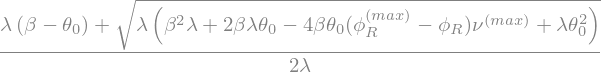

In [97]:
sp.init_printing()

# Define the symbols
nu_max = sp.Symbol('{{\\nu^{(max)}}}')
theta_0 = sp.Symbol('\\theta_0')
theta_a = sp.Symbol('\\theta_a')
beta = sp.Symbol('\\beta')
lam = sp.Symbol('\\lambda')
phir_max = sp.Symbol('{{(\\phi_R^{(max)} - \\phi_R)}}')

# Define Eq with MM nu
eq27 = theta_a + (beta / lam) * ((nu_max / (1 + (theta_a/theta_0))) * phir_max - lam)
theta_a_soln = sp.solve(eq27, theta_a)
theta_a_soln[1].simplify()


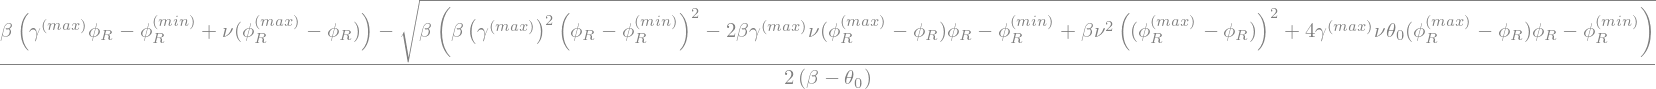

In [92]:
# Define the symbols. 
sp.init_printing()
gamma_max = sp.Symbol('\\gamma^{(max)}')
phir_min = sp.Symbol('{{\\phi_R - \\phi_R^{(min)}}}')
phir_max = sp.Symbol('{{(\\phi_R^{(max)} - \\phi_R)}}')
beta = sp.Symbol('\\beta')

nu = sp.Symbol('\\nu')
lam = sp.Symbol('\\lambda')

# Define the expression (Eq. 26)
eq = lam - (gamma_max * phir_min)/(1 + (theta_0)/(beta * ((nu/lam) * phir_max -1)))

# Solve for lambda 
soln = sp.solve(eq, lam)
soln[0]

While nasty, this is a rather concise expression for calculating the growth rate given knowledge of the ribosomal mass fraction *and* having some knowledge of how the translational capacity changes as a function of the nutrient concentration. It's difficult to look at Equation 28 and see its profile, so below we set up a small plot

In [5]:
# Define a function for Equation 28. 
def compute_growthrate(phi_R, gamma_max, nu, theta_0,
                        phi_R_max=0.7, phi_R_min=0.04,
                        beta=1):
    """
    Computes the steady-state growth rate. 

    Parameters
    ----------
    phi_R: float or numpy array
        The ribosomal mass fraction of the proteome. Must be between 0 and 1
    gamma_max: float or numpy array
        The maximum translational capacity in dimensions of inverse time. 
    nu: float or numpy array 
        The nutritional capacity of the system. Note that this is assumed 
        to be indepenent of the nutrient and is a fixed value. 
    theta_0 : float or numpy array
        The Michaelis-Menten constant of the nutrient mass fraction.
    """
    # Compute the mass fraction differences for simplicity
    phi_R_min_quant = phi_R - phi_R_min
    phi_R_max_quant = phi_R_max - phi_R
    
    # Compute the numerator piecewise
    prefix = beta * (gamma_max * phi_R_min_quant + nu * phi_R_max_quant)
    sqrt_a = beta * (gamma_max * phi_R_min_quant)**2
    sqrt_b = 2 * beta * gamma_max * nu * phi_R_min_quant * phi_R_max_quant
    sqrt_c = beta * (nu * phi_R_max_quant)**2
    sqrt_d = 4 * gamma_max * nu * theta_0 * phi_R_min_quant * phi_R_max_quant
    numer = prefix - np.sqrt(beta * (sqrt_a - sqrt_b + sqrt_c + sqrt_d))
    denom = 2 * beta - theta_0
    return numer / denom

# Define the ribosomal mass fraction and instantiate the dataframe
phi_r = np.linspace(0, 1, 200)
gr_df = pd.DataFrame(phi_r.T, columns=['phi_R'])
gr_df['rate_hr'] = compute_growthrate(phi_r, 20, 10, 0.03)


# Set up the plot. 
base = alt.Chart(gr_df).mark_line().encode(
            x=alt.X(field='phi_R', type='quantitative', title='ribosomal mass fraction'),
            y=alt.Y(field='rate_hr', type='quantitative', title='growth rate [T\u207b\u00b9]'))
base

alt.Chart(...)